In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statannotations.Annotator import Annotator
palette = sns.color_palette('colorblind')
sns.set_palette(palette)
sns.set(context='paper', style='white', font='CMU Serif',
    rc={'font.size':12, 'mathtext.fontset': 'cm', 'axes.labelpad':0, 'axes.linewidth': 0.5})

## WM

In [23]:
data = pd.read_pickle(f"data/WMz1.pkl")
sids = data['sid'].unique()
errors1 = []
for sid in sids:
    df = data.query("sid==@sid")
    human_actions = df.query("type=='human'")['action'].to_numpy()
    model_actions = df.query("type=='model-WM'")['action'].to_numpy()
    error = len(np.where(model_actions != human_actions)[0]) / len(human_actions)
    errors1.append(error)

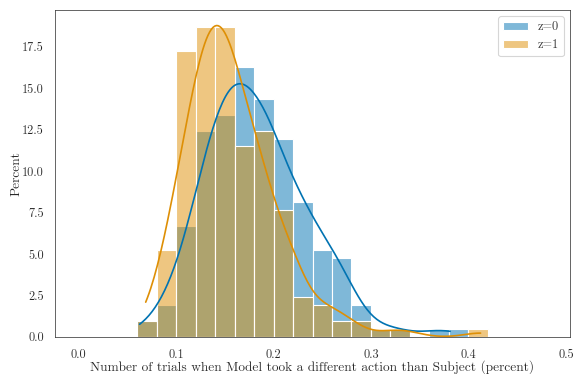

In [24]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
bins = np.arange(0.0, 0.5, 0.02)
sns.histplot(errors0, ax=ax, stat='percent', color=palette[0], label='z=0', bins=bins, kde=True)
sns.histplot(errors1, ax=ax, stat='percent', color=palette[1], label='z=1', bins=bins, kde=True)
ax.set(xlabel="Number of trials when Model took a different action than Subject (percent)") 
ax.legend()
plt.tight_layout()
fig.savefig("plots/wm_errors.png", dpi=600)

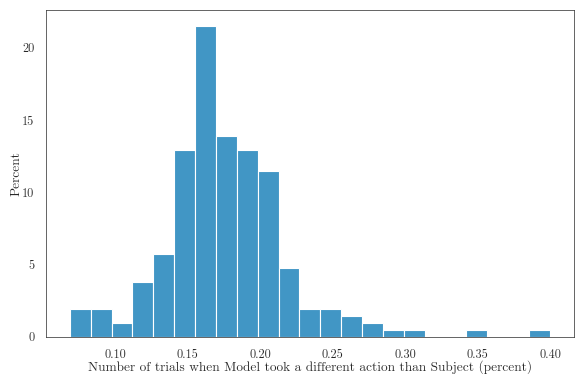

In [41]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
sns.histplot(errors0, ax=ax, stat='percent', color=palette[0], label='z=0')
sns.histplot(errors1, ax=ax, stat='percent', color=palette[1], label='z=1')
ax.set(xlabel="Number of trials when Model took a different action than Subject (percent)") 
plt.tight_layout()
fig.savefig("plots/wm_errors.png", dpi=600)

In [18]:
empirical = pd.read_pickle("data/behavior.pkl")
print(empirical['RD'].max())

0.83333
